In [27]:
import numpy as np
import torch
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torchvision.transforms as T
import torchvision.datasets 

import data
import utils

In [22]:
# Label-wise variance-based measures
def total_uncertainty_variance(probs):
    if isinstance(probs, torch.Tensor):
        probs = probs.detach().numpy()
    mean = np.mean(probs, axis=2)
    t_u = mean * (1-mean)
    return t_u 
    

def aleatoric_uncertainty_variance(probs):
    if isinstance(probs, torch.Tensor):
        probs = probs.detach().numpy()
    mean = np.mean(probs, axis=2)
    a_u = np.mean(probs*(1-probs), axis=2)
    #a_u = a_u / (mean)
    #a_u = a_u / (1-mean)
    return a_u 

def epistemic_uncertainty_variance(probs):
    if isinstance(probs, torch.Tensor):
        probs = probs.detach().numpy()
    # S = np.sum(probs, axis = 1, keepdims = True) 
    # m = probs/S
    # e_u = np.sum(m*(1-m), axis=1) / (S.squeeze()+1)
    mean = np.mean(probs, axis=2, keepdims=1)
    e_u = np.mean(probs*(probs-mean), axis=2)
    #e_u = e_u / (mean).squeeze()
    #e_u = e_u / (1-mean).squeeze()
    return e_u 

In [23]:
# Create a figure object with 2 rows and 3 columns of subplots
def plot_images(ind, test_set, au_data, eu_data, y_up = 0.25, height = 13, save = False, save_name = None):
  n = len(ind)
  cols = n//3 + n%3
  rows = n// cols + (n%cols>0)

  fig = plt.figure(figsize=(cols*10, rows*height))

  # Define the labels and colors for the barplot
  labels = [f'{k}' for k in range(10)]

  # Loop over the subplots and plot the images and barplots
  for i in range(n):
    # Create an axes object for the subplot
    ax = fig.add_subplot(rows, cols, i + 1)
    # Plot the image
    ax.imshow(test_set[ind[i]][0])
    ax.axis('off') # turns off the axis
    # Predict the probabilities 
    # Create a new axes object for the barplot below the image
    ax2 = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.3/rows, ax.get_position().width, 0.3/rows])
    # Plot the barplot
    ax2.bar(labels, eu_data[i], label = 'EU')
    ax2.bar(labels, au_data[i], color='red', bottom=eu_data[i], label = 'AU')
    ax2.set_ylim(0, y_up) # set the y-axis limit
    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels, fontsize = 15)  
    #ax2.set_xticks([]) # remove the x-axis ticks
    ax2.set_yticks([0, 0.1, 0.25]) # set the y-axis ticks
    plt.yticks(fontsize=15)
    ax2.legend(fontsize = 20)
  #plt.tight_layout()
  # Display the figure
  if save:
    plt.savefig(f"./image_scores/{save_name}.pdf", bbox_inches="tight")
  plt.show()

In [24]:
if not os.path.exists('./test_files/'):
            os.makedirs('./test_files/')

datasets = ['mnist']
for dataset in datasets:
    _, x = data.get_data(f'{dataset}', flatten = False) 
    for seed in range(5):
        seed +=1
        model = torch.load(f'./checkpoints/{dataset}_{seed}.pt', map_location=torch.device('cpu'))
        probs, y = utils.torch_get_outputs(model, x)
        probs = probs.detach().numpy()
        np.save(f'./test_files/probs_{dataset}_{seed}.npy', probs)
    y = y.detach().numpy()
    np.save(f'./test_files/y_{dataset}.npy', y)

In [25]:
y = np.load('./test_files/y_mnist.npy')
probs = np.load('./test_files/probs_mnist_1.npy')
mean = probs.mean(-1)

au = aleatoric_uncertainty_variance(probs) 
eu = epistemic_uncertainty_variance(probs) 
tu = au+eu
test_set = torchvision.datasets.MNIST(root='~/datasets/', train=False, download=True) # create a dataset object

au_9 = np.argpartition(au.sum(1), -9)[-9:]
eu_9 = np.argpartition(eu.sum(1), -9)[-9:]
tu_9 = np.argpartition(tu.sum(1), -9)[-9:]

[3559 2742  646 4078 9692  247 6572 4443 1414] tu


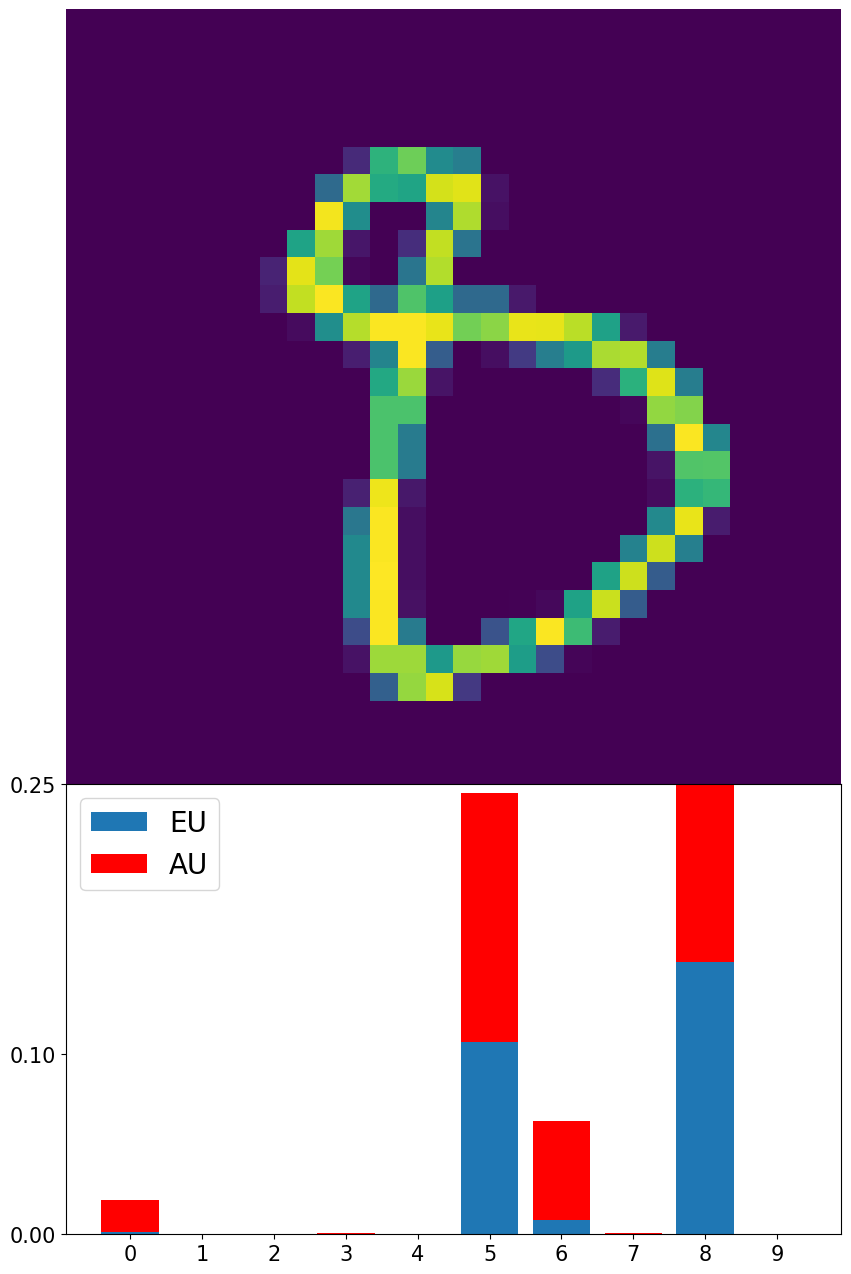

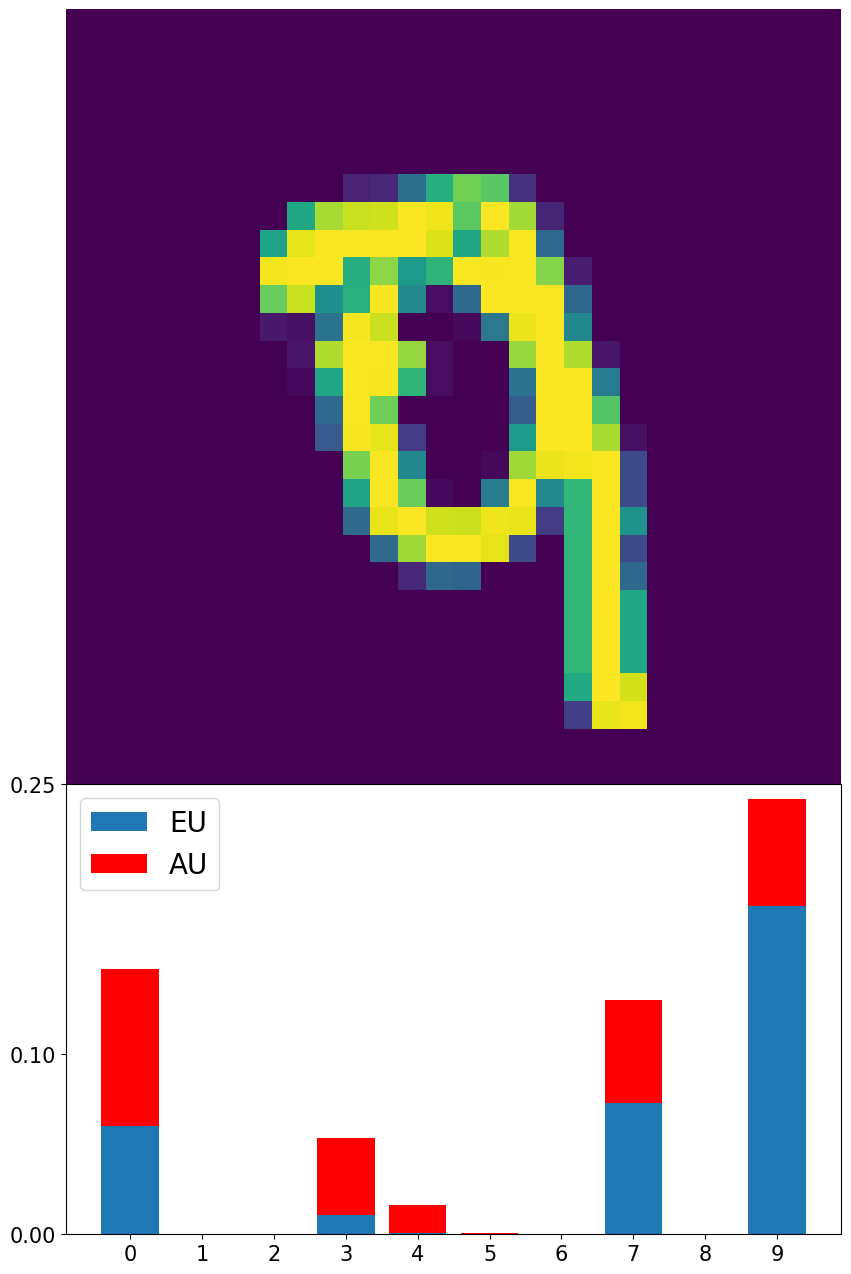

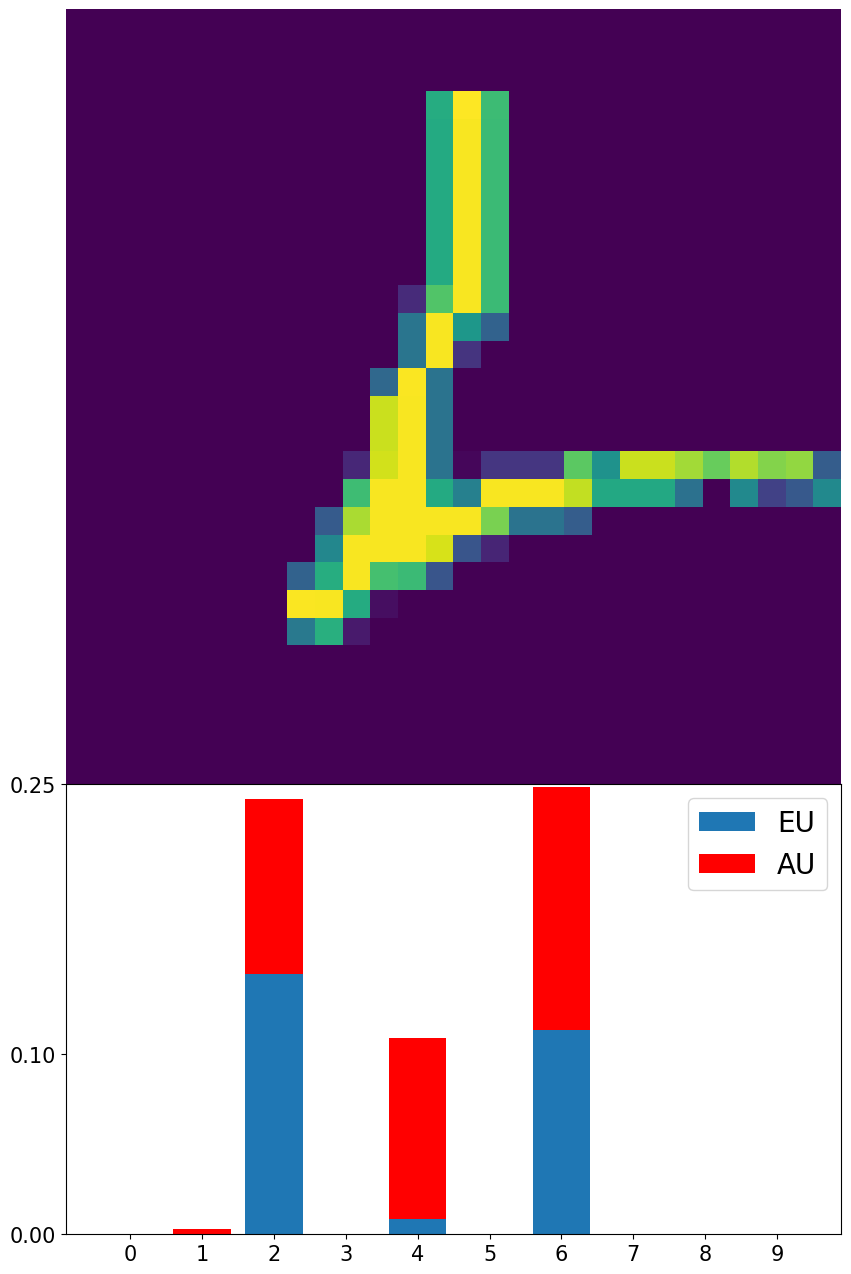

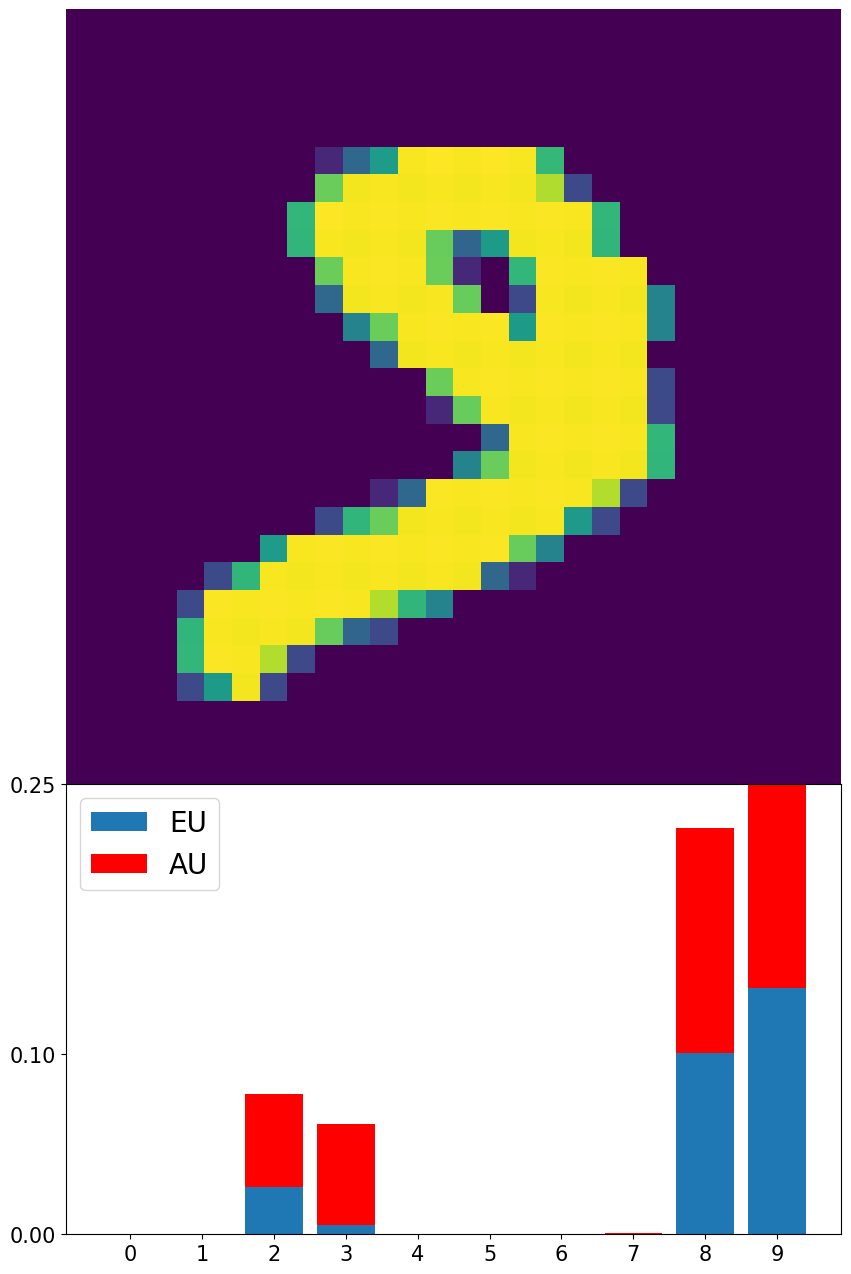

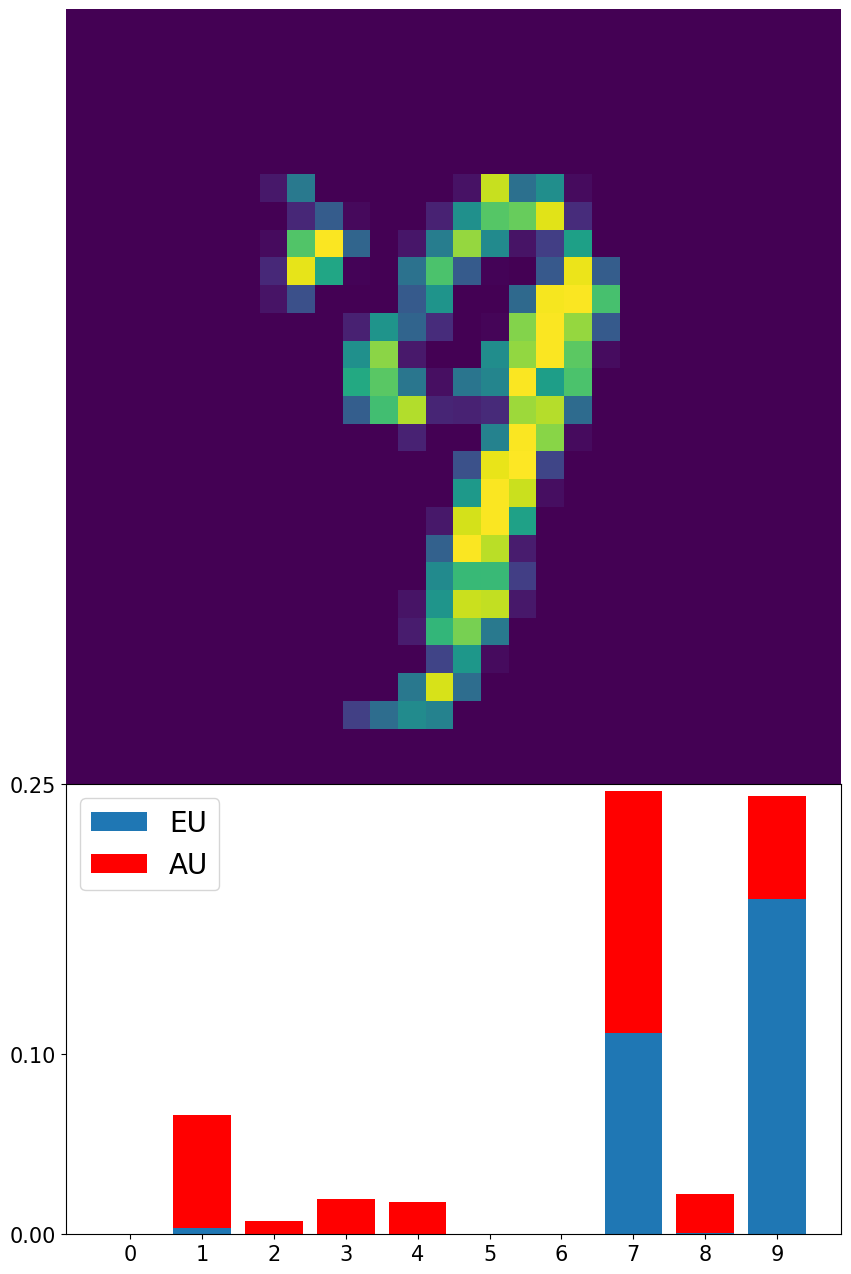

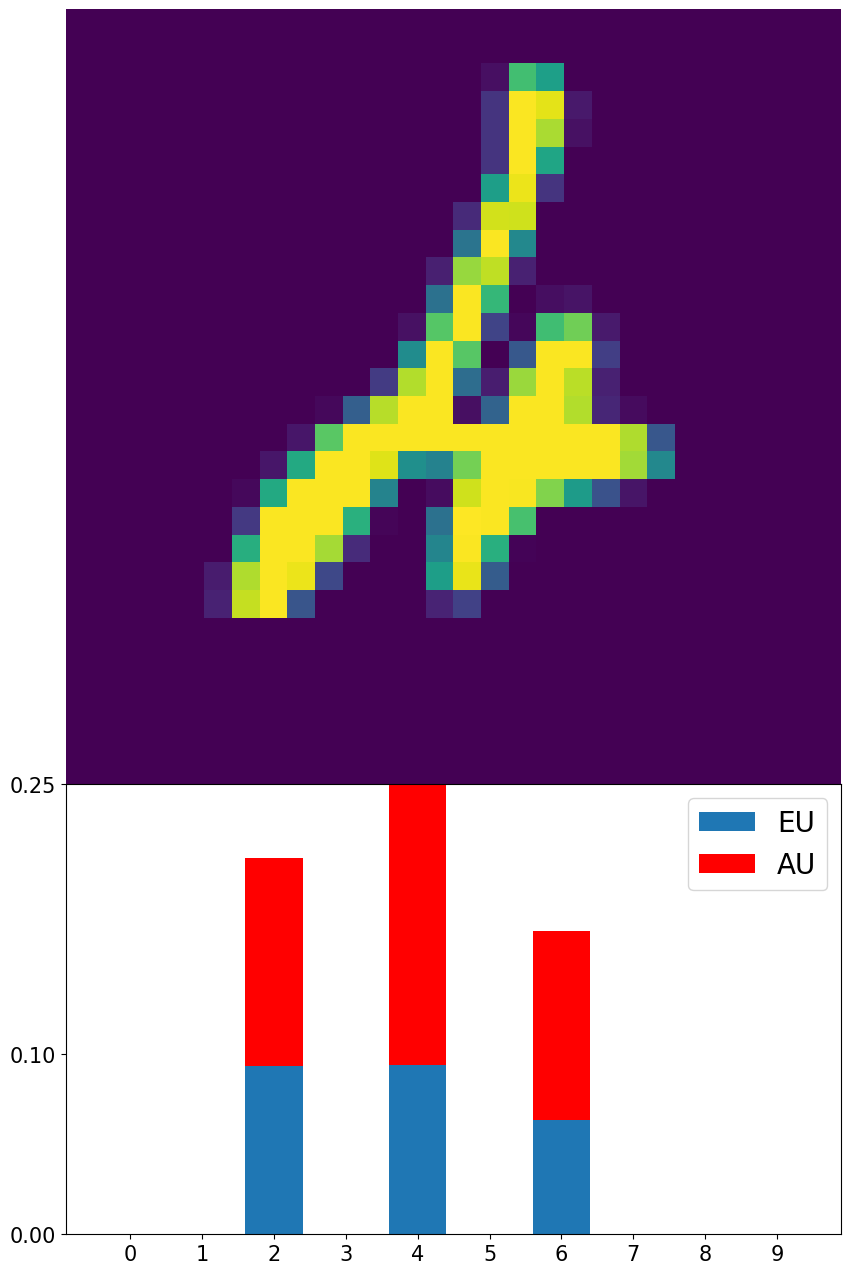

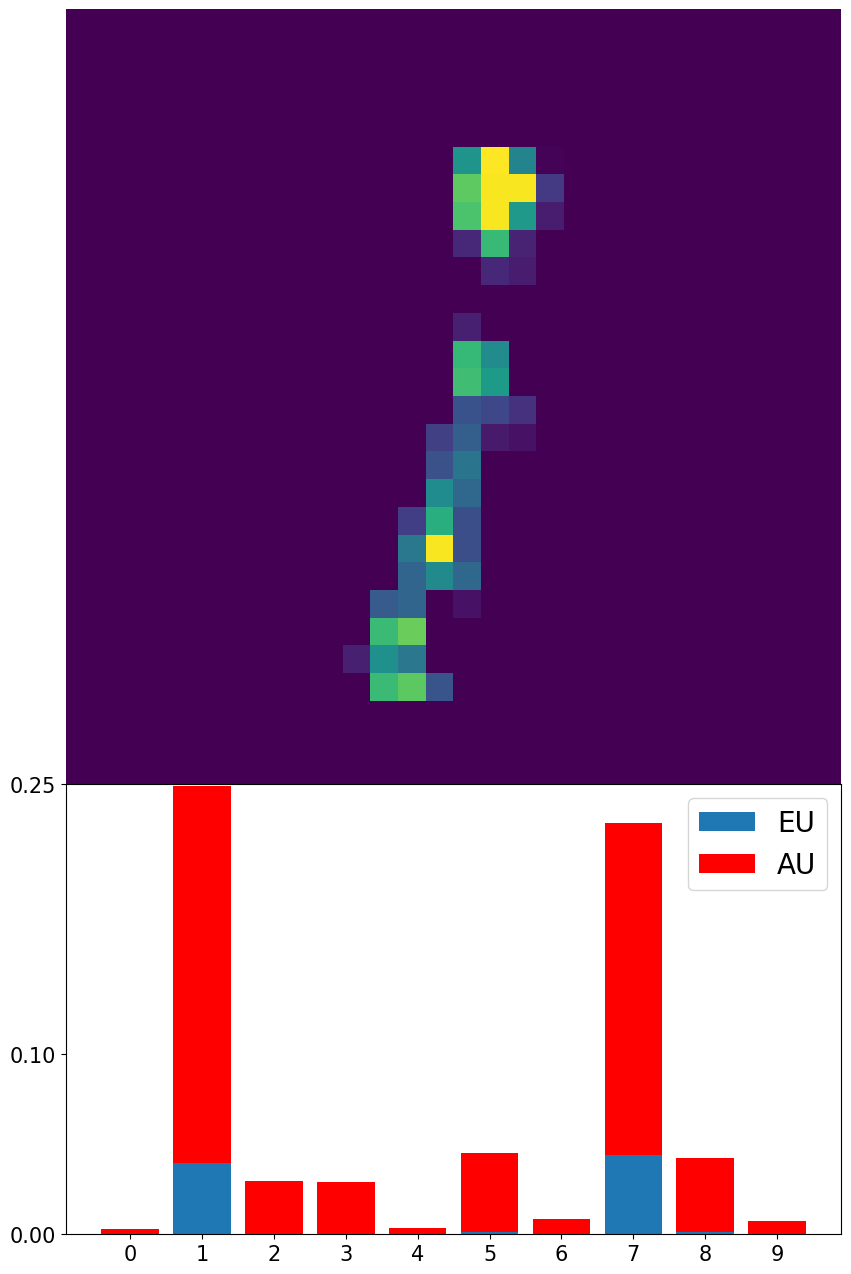

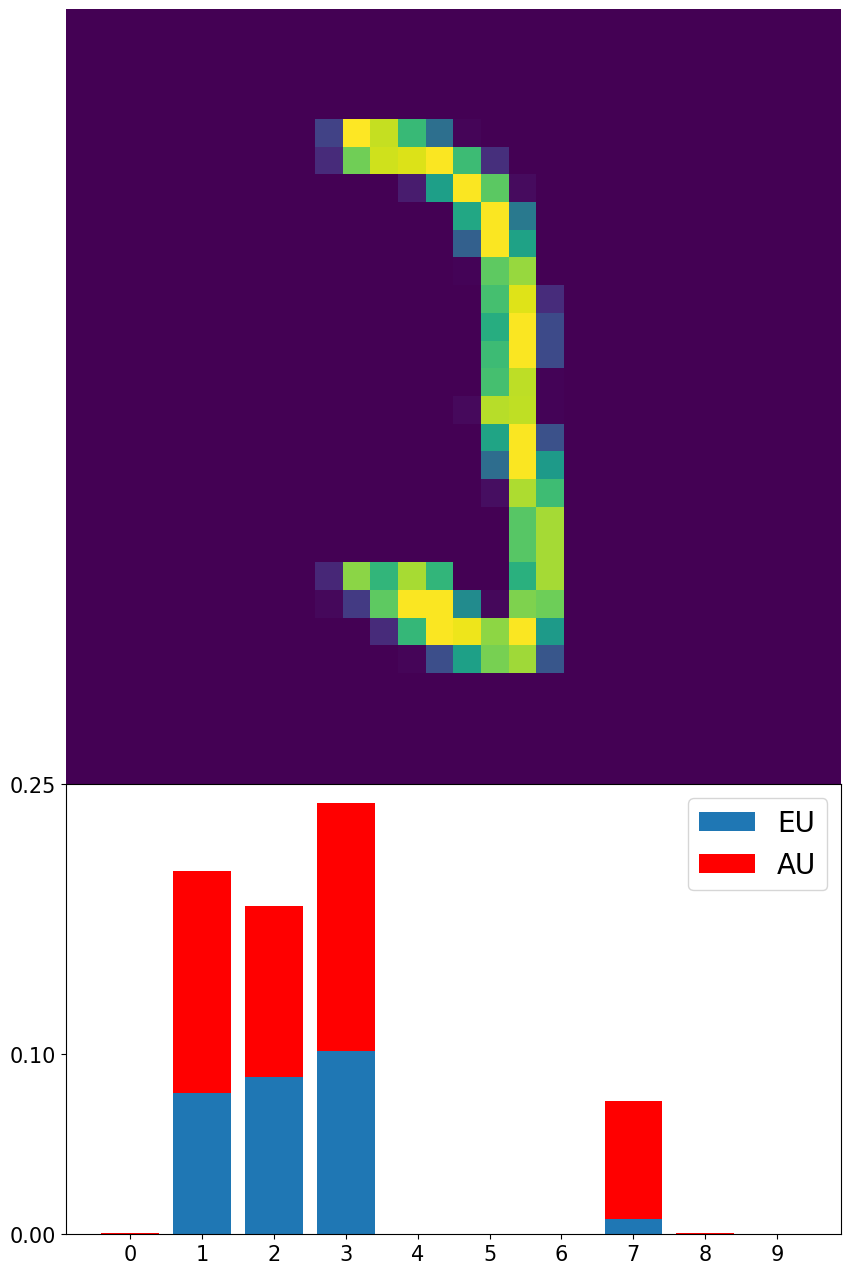

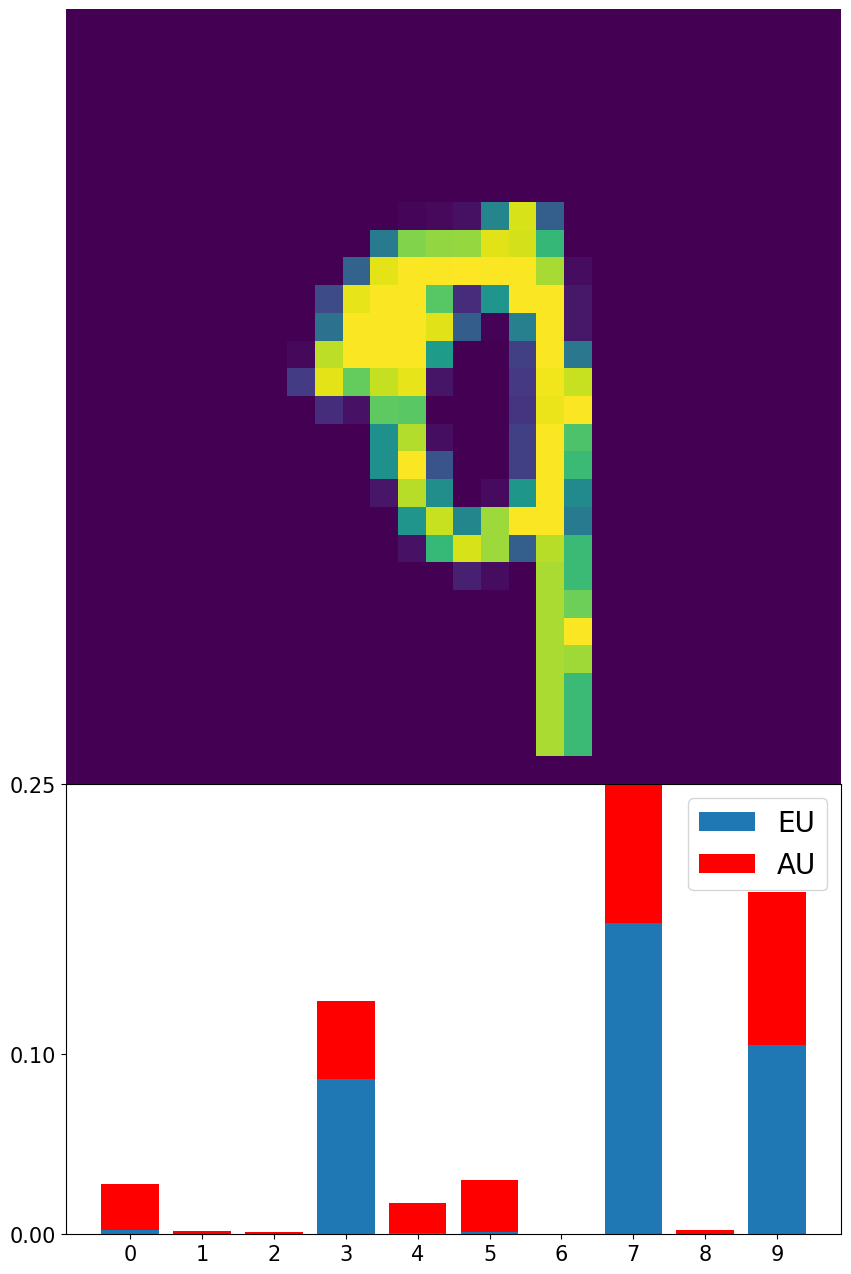

[8527 3558 1039 2293 2720 6572 4443 6571 2939] au


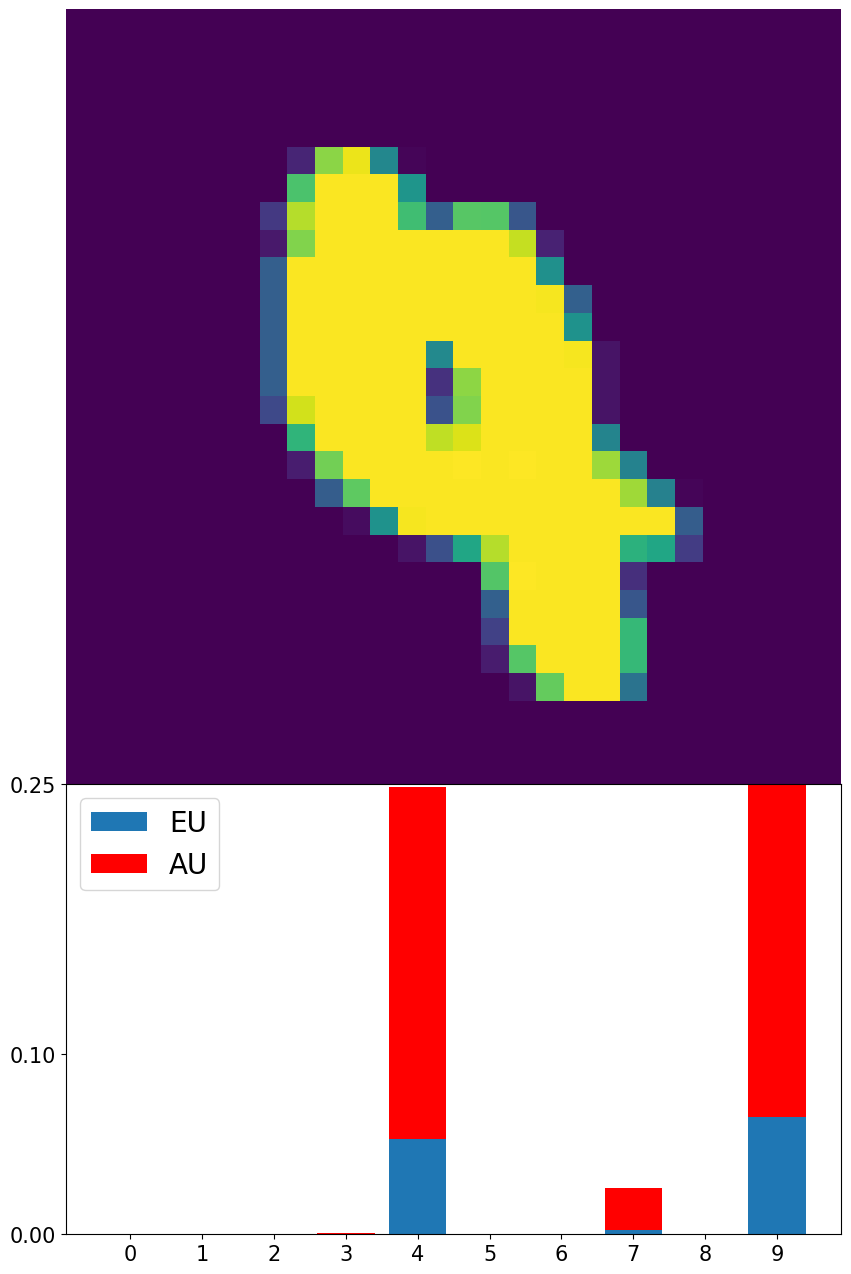

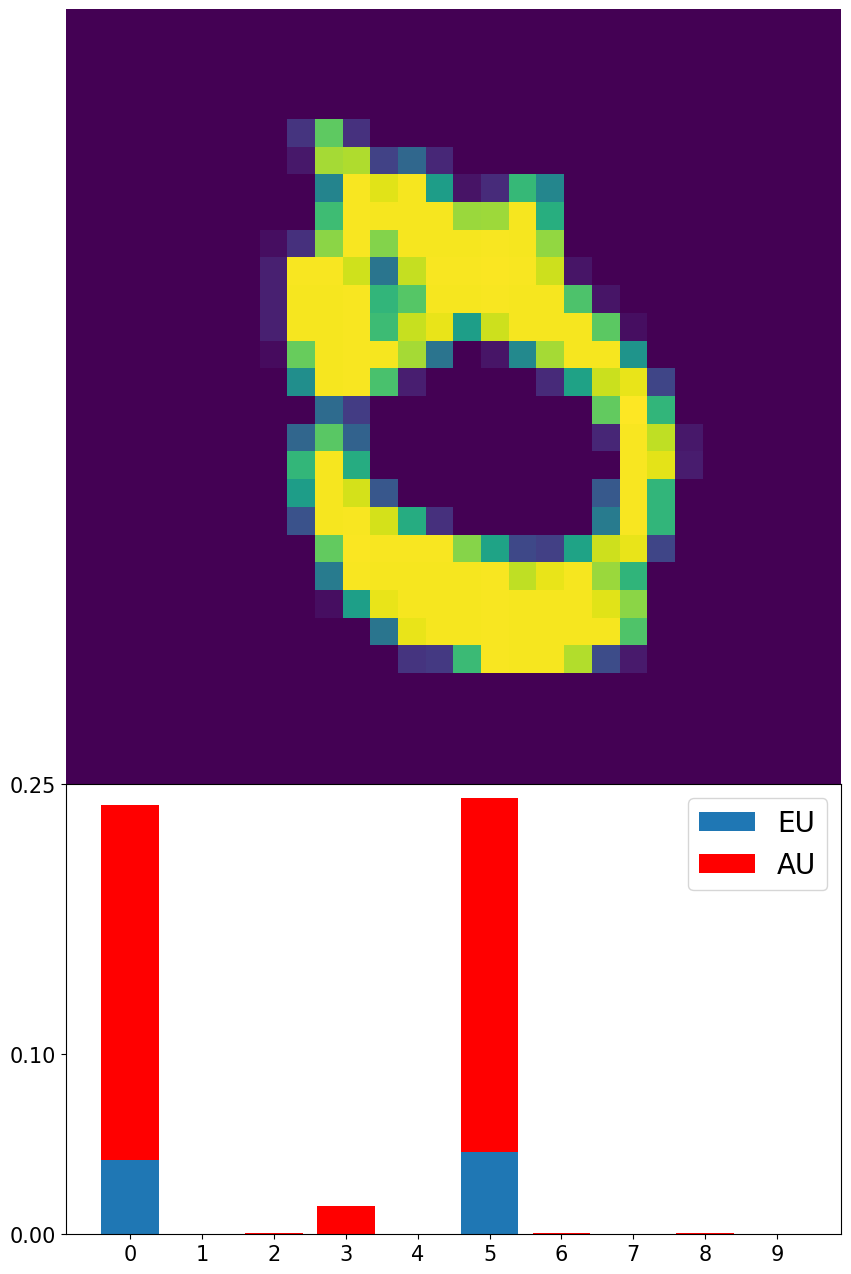

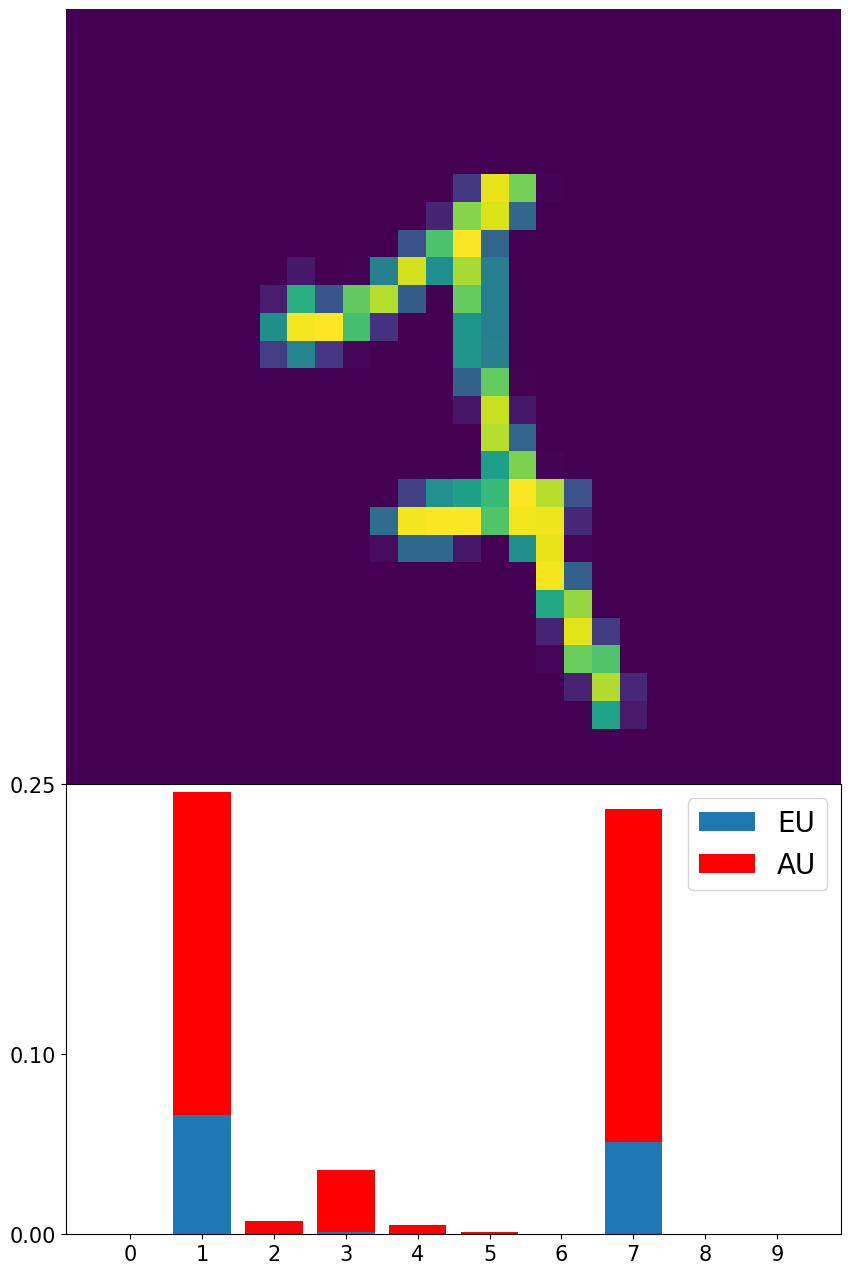

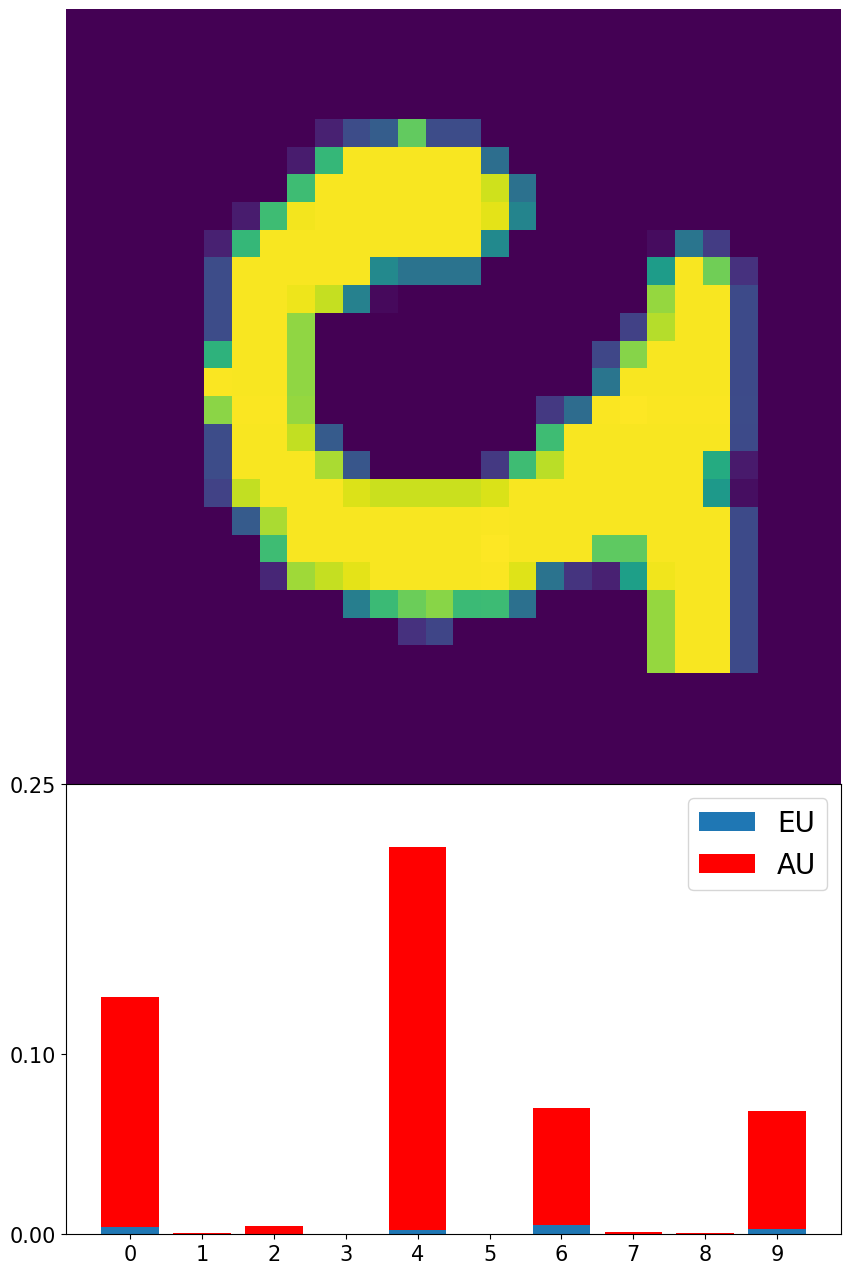

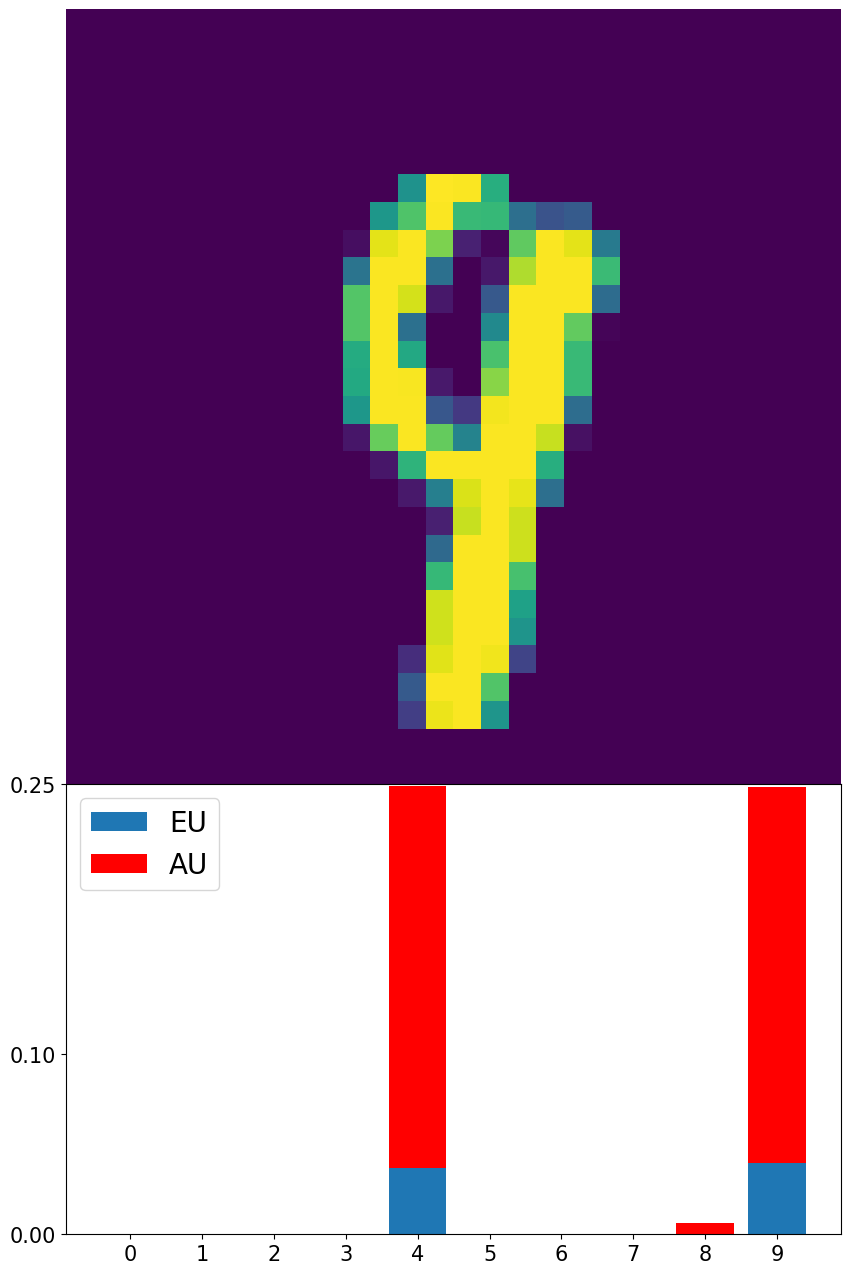

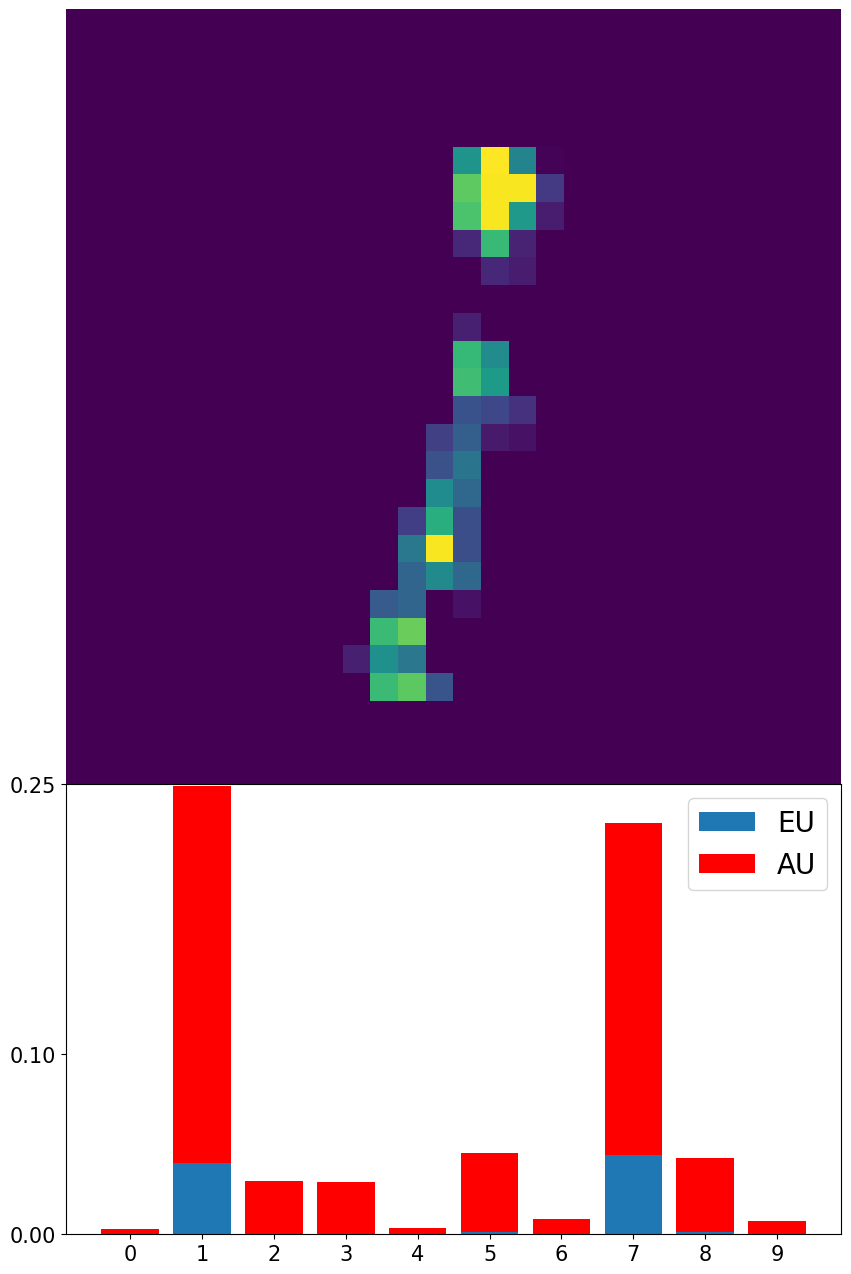

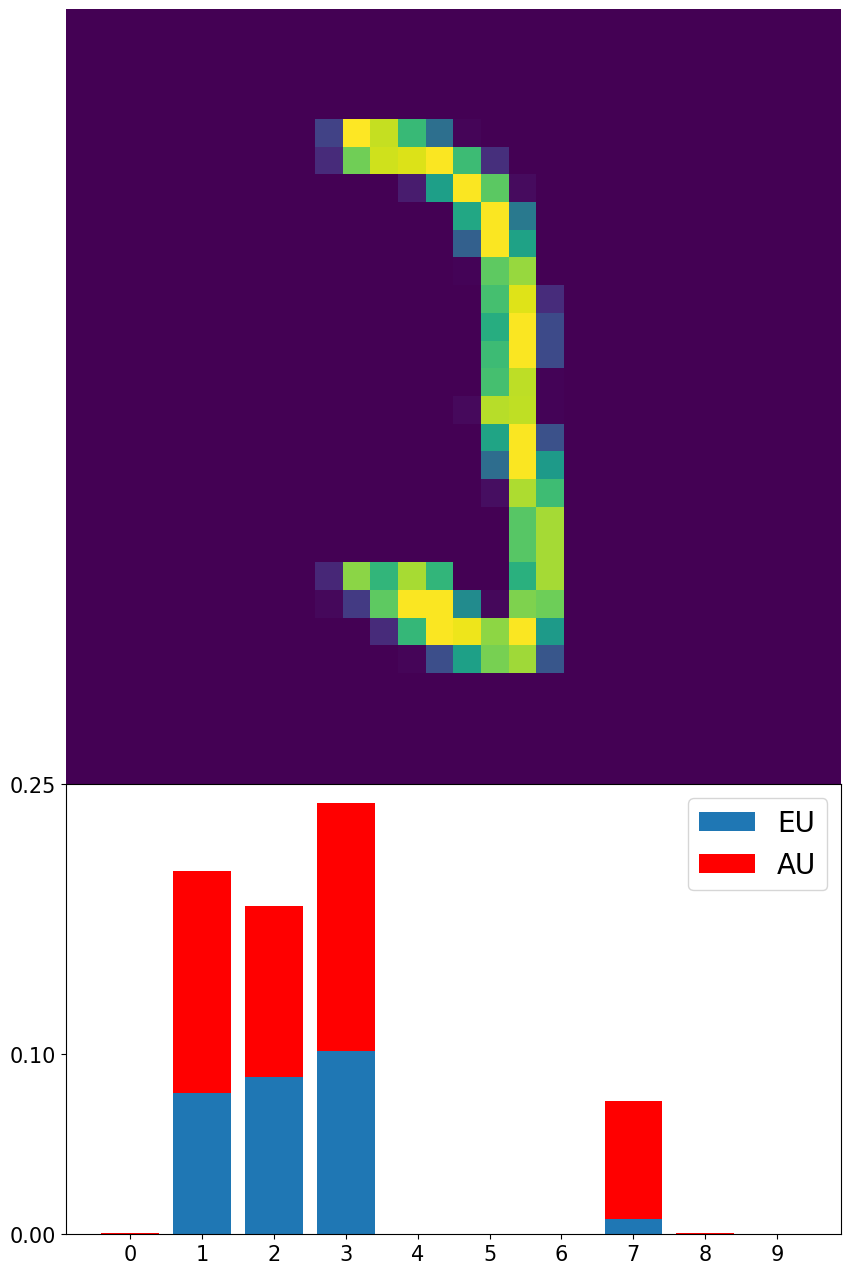

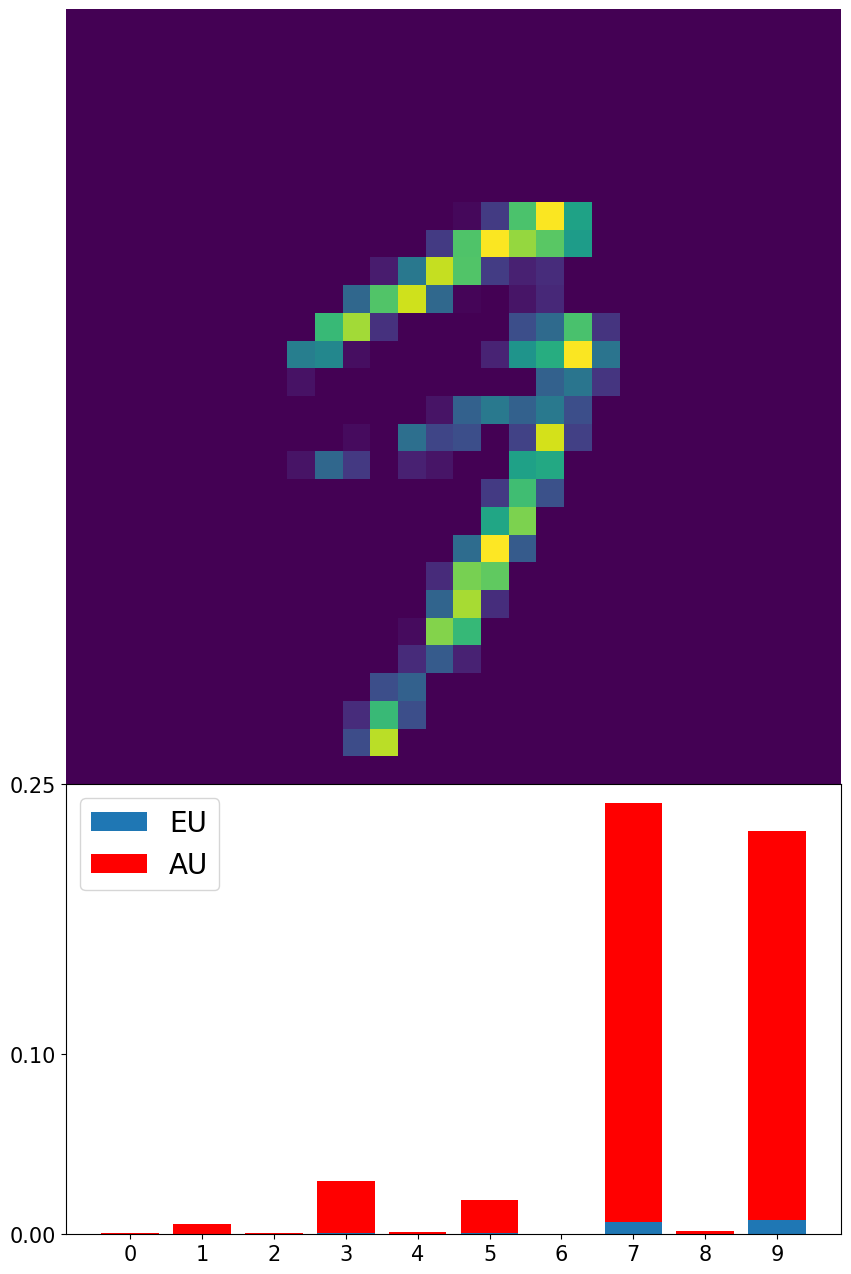

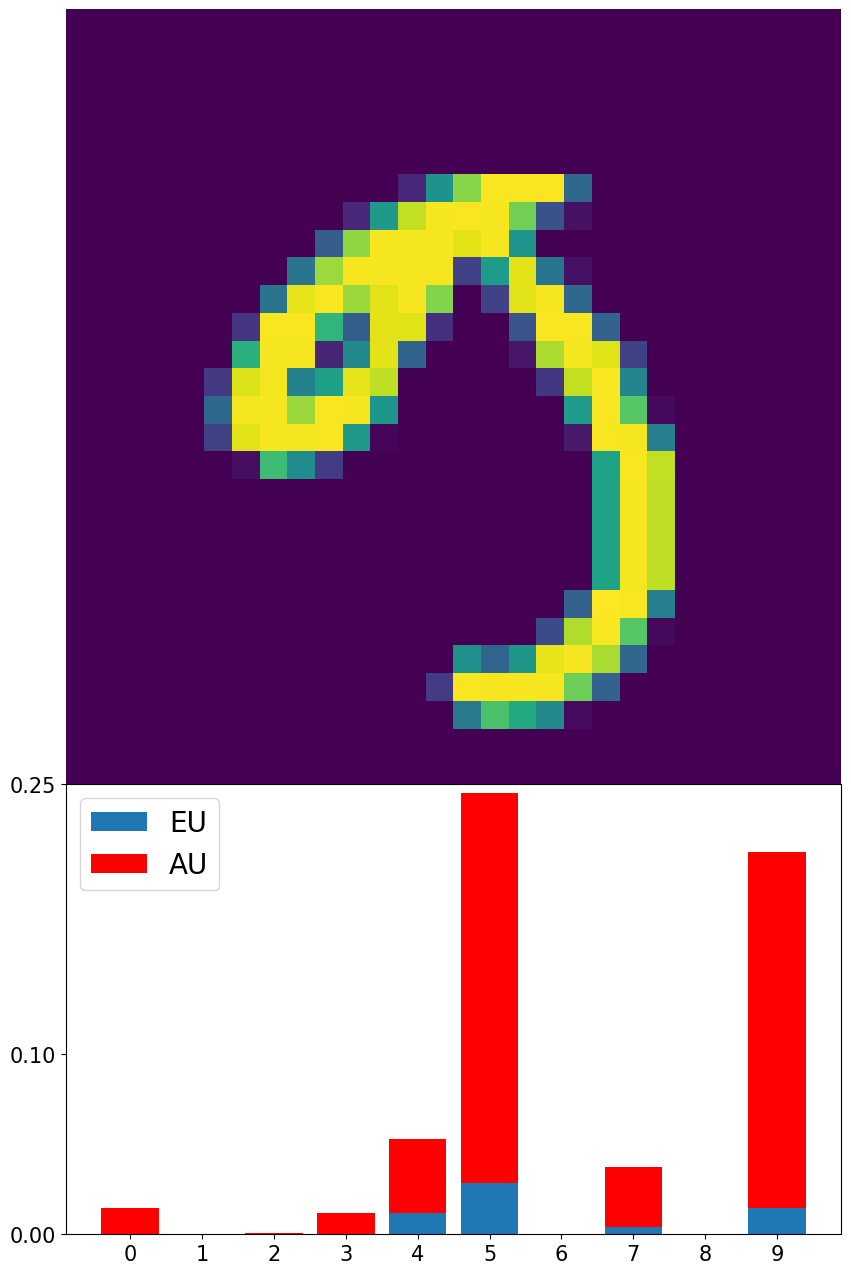

[2742 2070 3906 9755 5654 1414 1319 4620 5457] eu


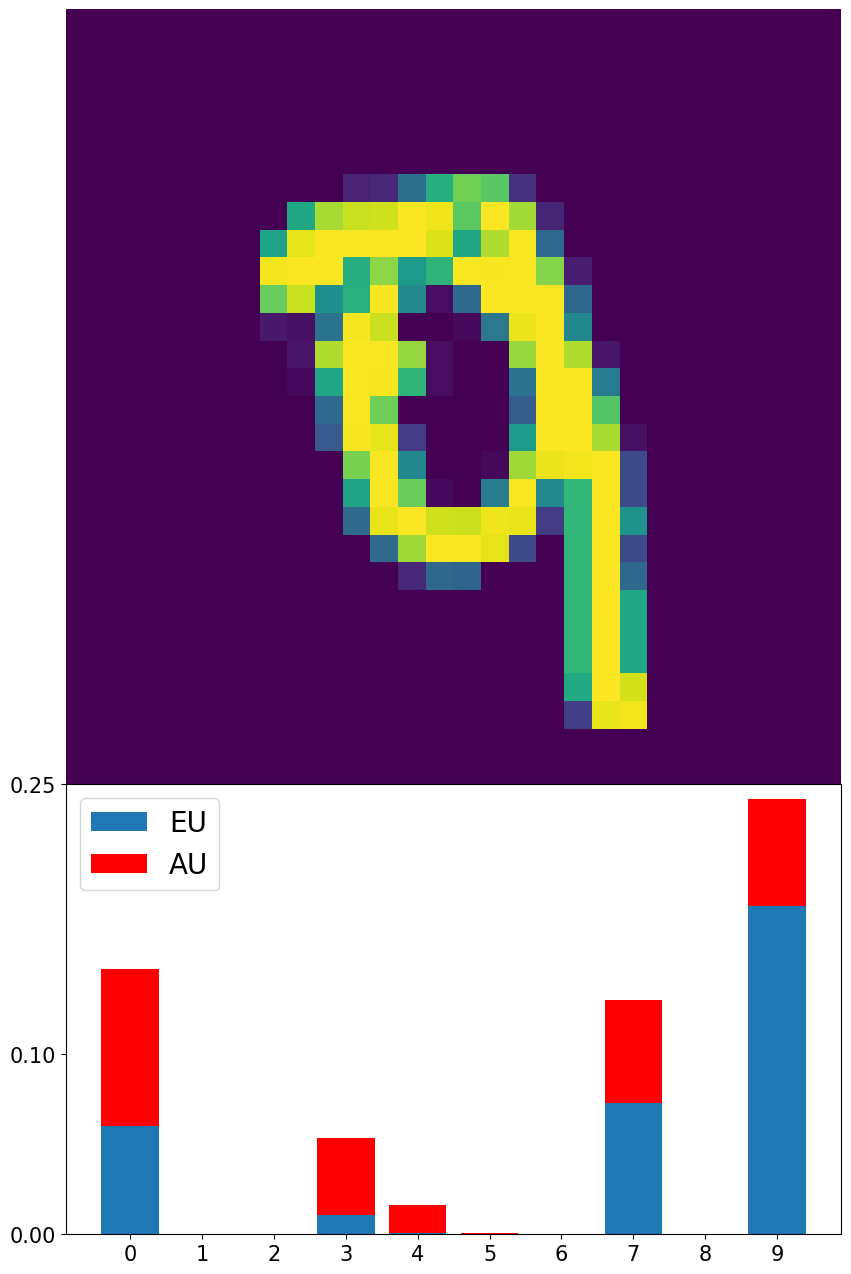

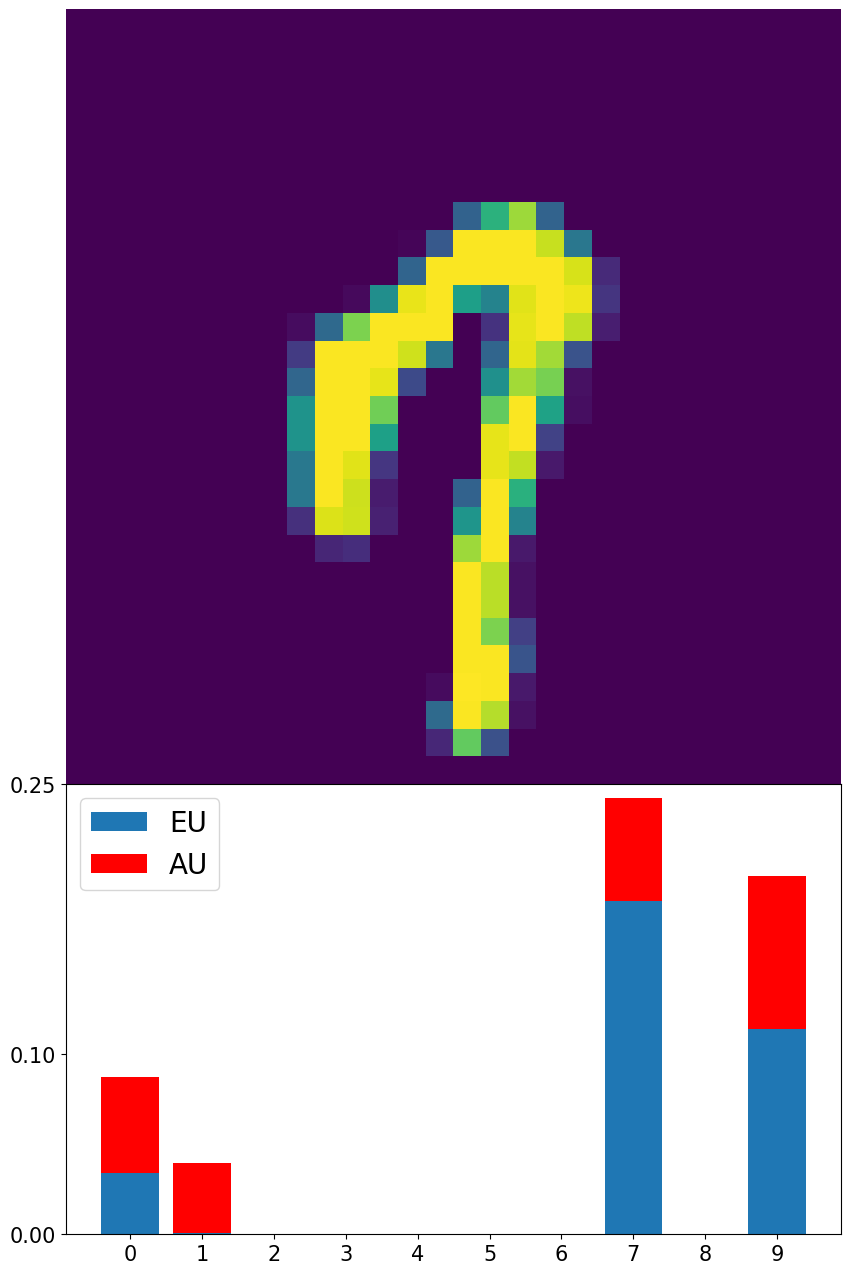

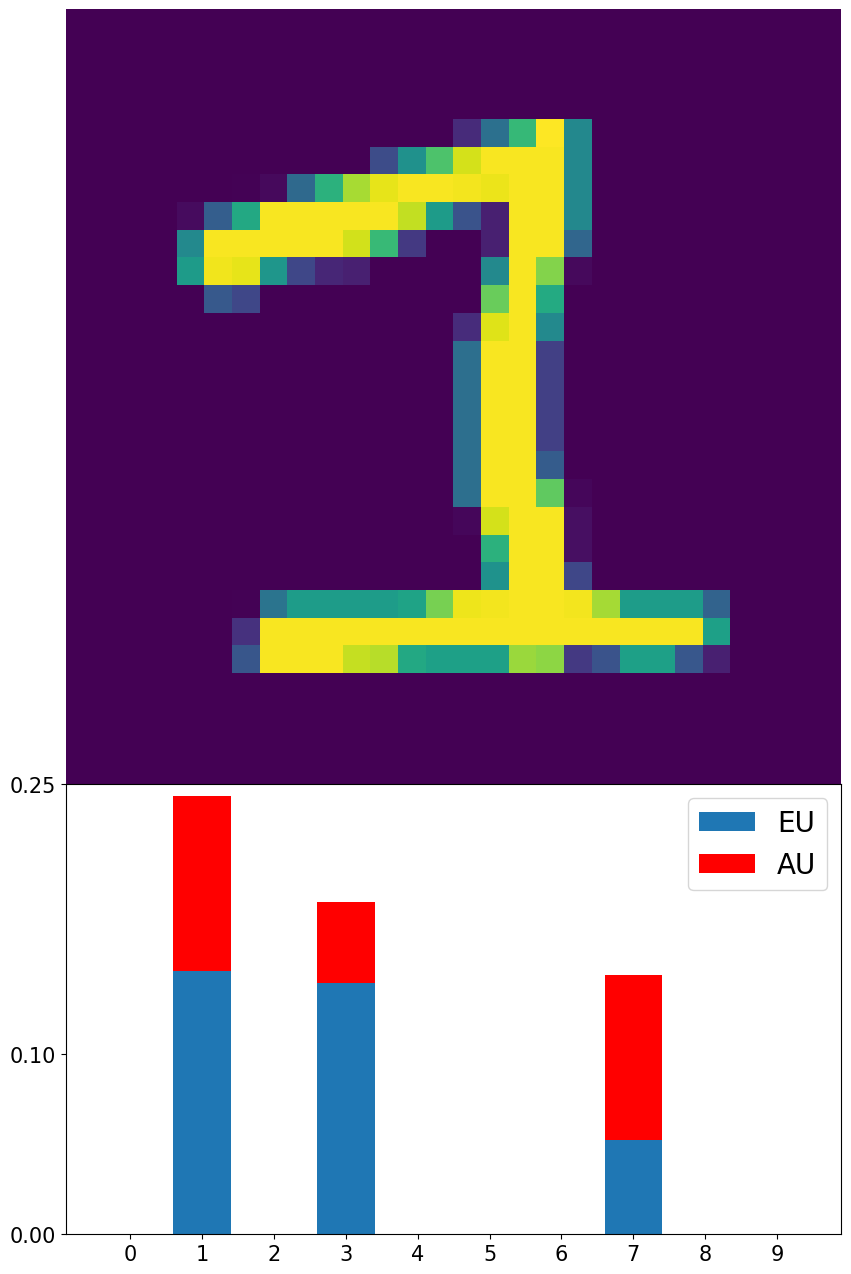

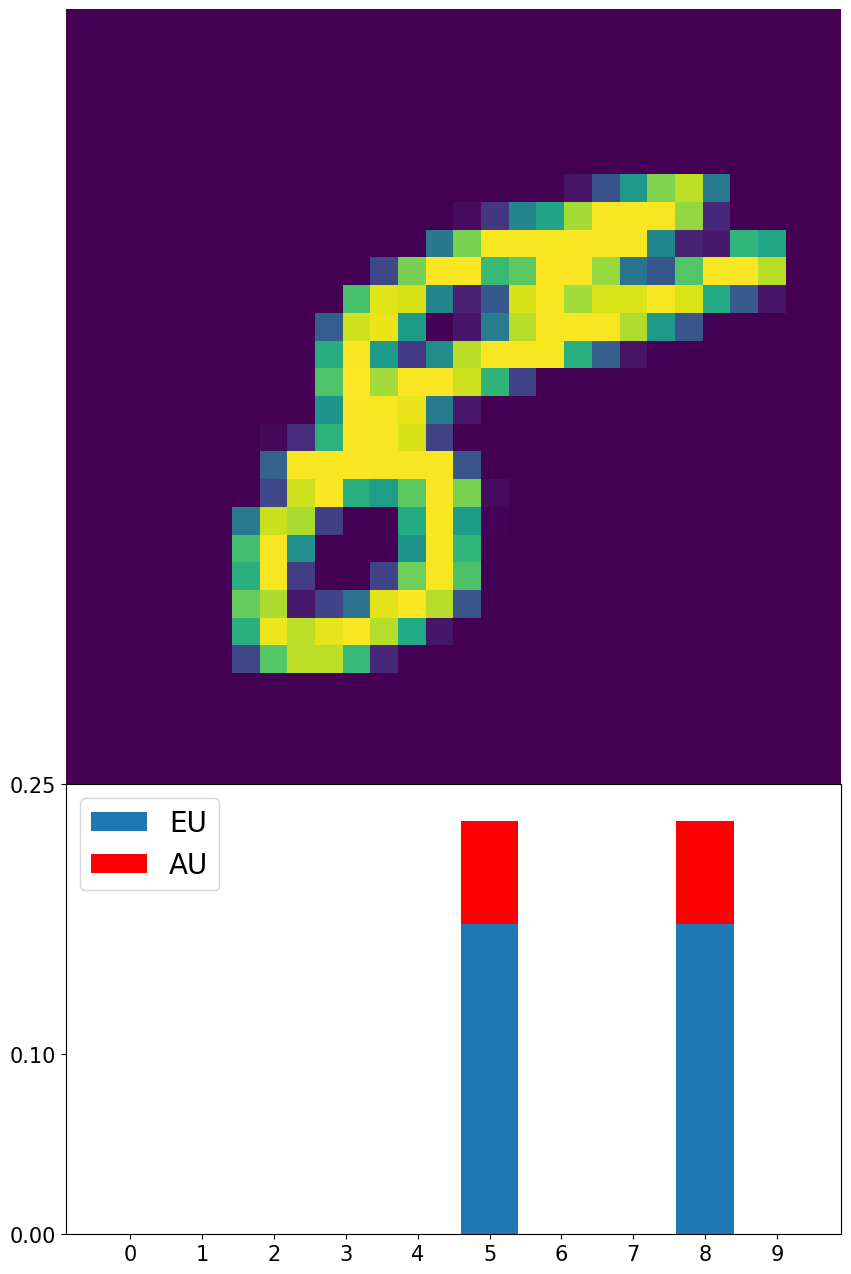

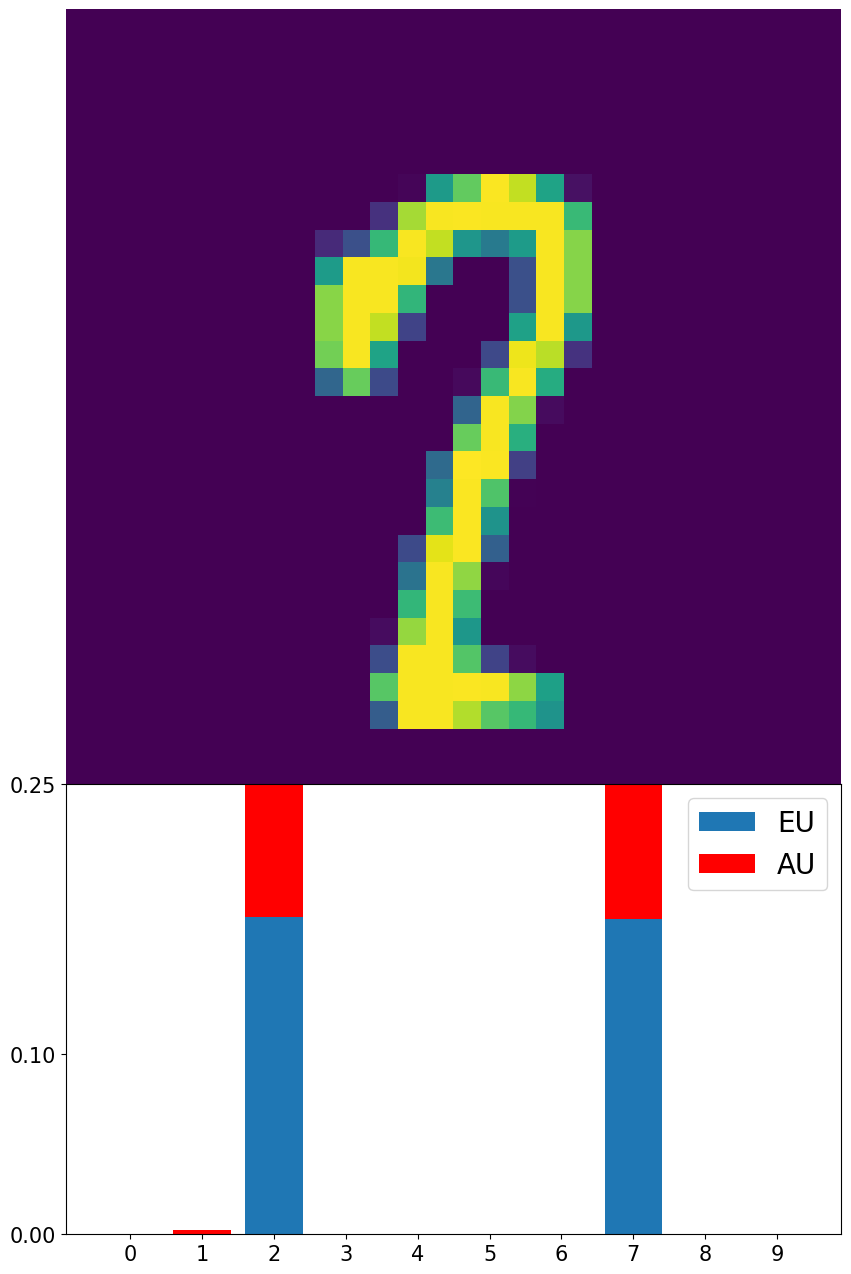

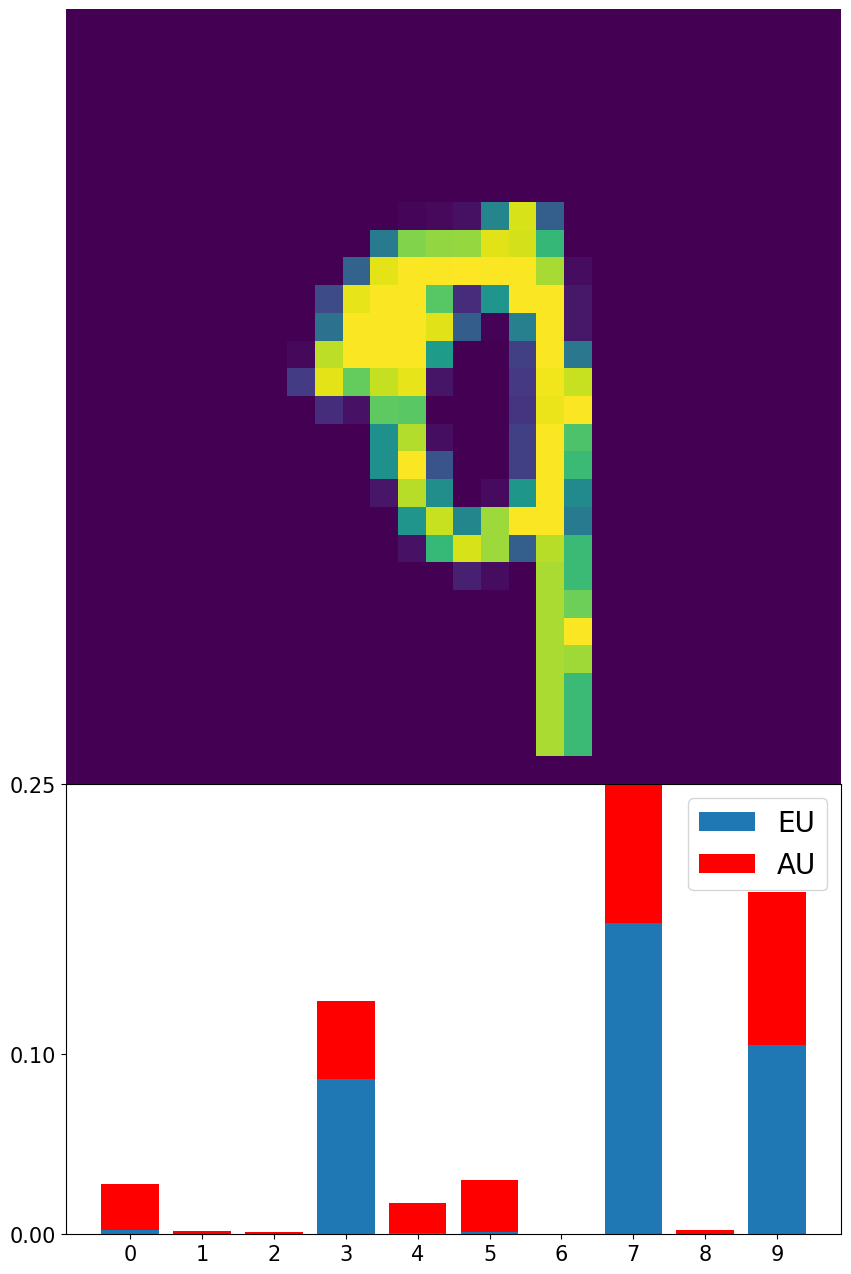

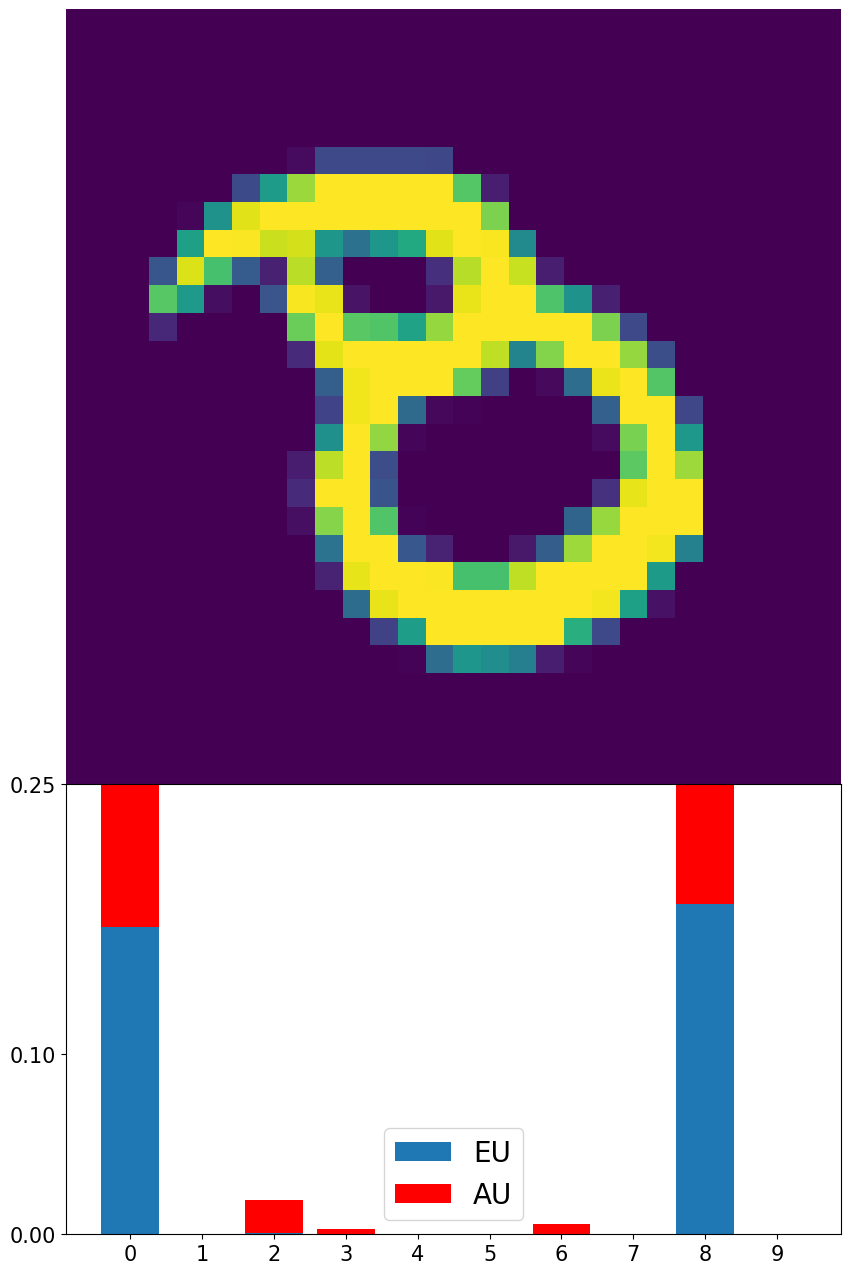

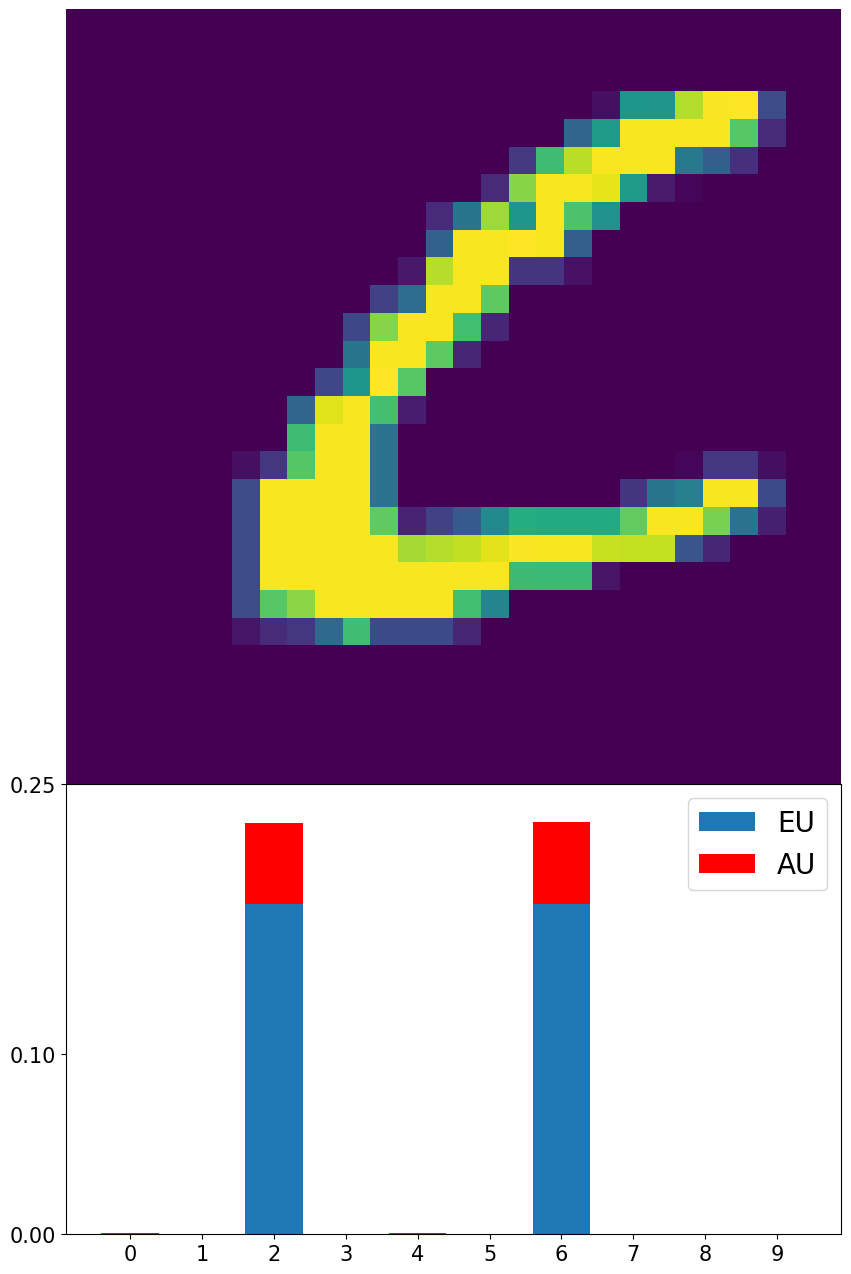

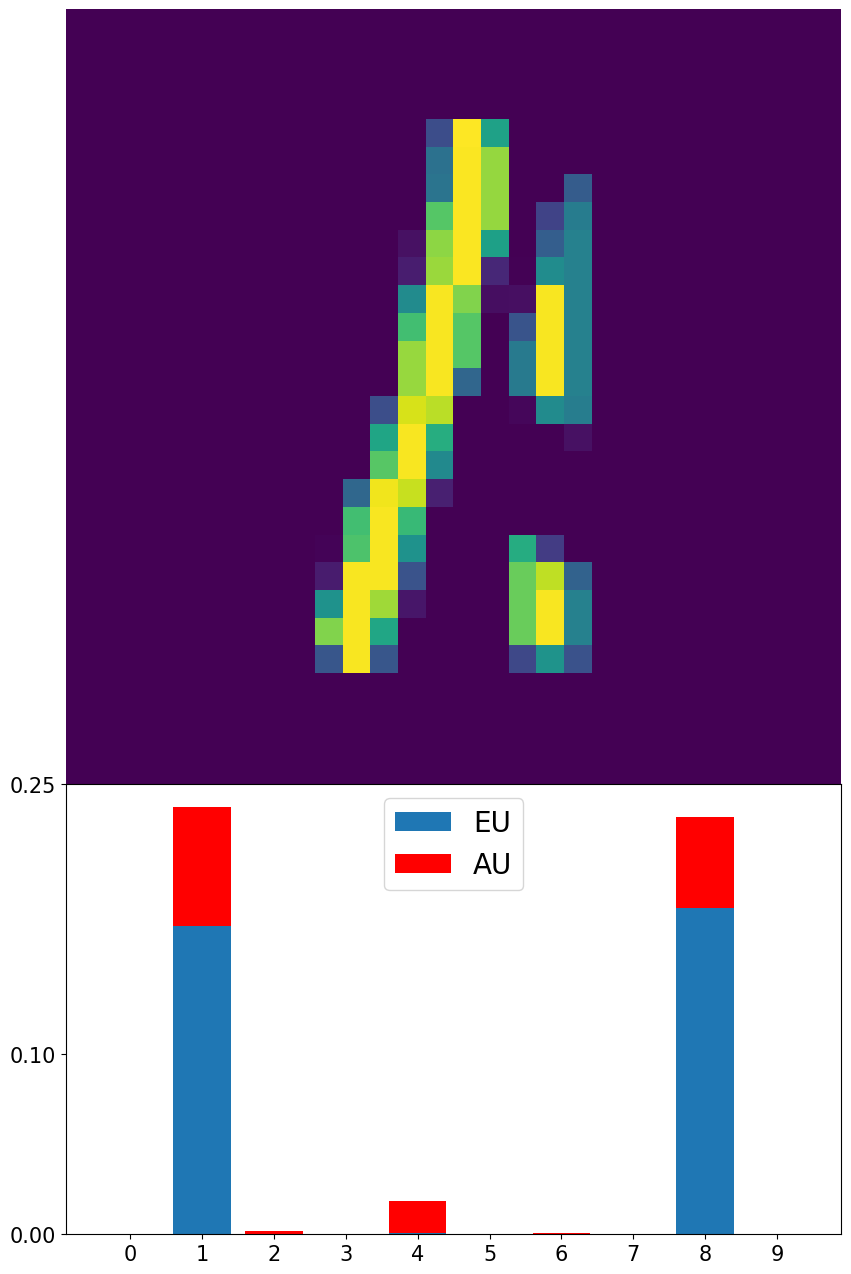

In [26]:
if not os.path.exists('./image_scores/'):
            os.makedirs('./image_scores/')
au_ind = au_9
eu_ind = eu_9
tu_ind = tu_9
ind_list = [[x,y,z] for x,y,z in zip(tu_ind, au_ind , eu_ind)]
ind_list = np.hstack(ind_list)

# plot_images(ind_list, au[ind_list], eu[ind_list], False, test_ind = True, data='mnist', height = 15, save=True, save_name='tu_au_eu')
for inds, name in zip([tu_ind, au_ind, eu_ind], ['tu', 'au', 'eu']):
    print(f'{inds} {name}')
    for i, ind in enumerate(inds):
        ind = [ind]
        plot_images(ind, test_set, au[ind], eu[ind], height = 15, save = True, save_name=f'mnist_{name}_{i}')